# Data Preparation

This notebook will be used to prepare the data for machine learning.

1. Annotate the dataset (Sleep 0 /Awake 1)
2. Signal Preparation (scaling, missing data, outliers, smoothing)
3. Subset generation (light, medium, heavy)

## Import


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

from tqdm import tqdm

## Data Preparation

**Convert timestamp to datetime**


In [2]:
timestamp = [
    pl.col("timestamp").str.to_datetime("%Y-%m-%dT%H:%M:%S%z")
]

**Min-max normalization**

In [3]:
min_max_normalization = lambda x: (x - x.min()) / (x.max() - x.min())
normalization = [
    pl.col("anglez").map_batches(min_max_normalization).cast(pl.Float32), 
    pl.col("enmo").map_batches(min_max_normalization).cast(pl.Float32),
    pl.col("step").cast(pl.UInt32),
]


**Data import**

In [4]:
df_signals = pl.scan_parquet("data/train_series.parquet").with_columns(
    timestamp + normalization
).collect(streaming=True)

In [5]:
df_events = pl.scan_csv("data/train_events.csv").with_columns(
    timestamp + [pl.col("step").cast(pl.UInt32)]
).drop_nulls().collect()

**Data cleaning**

In [6]:
# Removing null events and nights with mismatched counts from series_events
mismatches = df_events.group_by(['series_id', 'night']).agg(
    (pl.col('event') == 'onset').sum().alias('onset'),
    (pl.col('event') == 'wakeup').sum().alias('wakeup')
    ).sort(by=['series_id', 'night']).filter(pl.col('onset') != pl.col('wakeup')).select(pl.all().exclude('onset', 'wakeup'))
print(f"The mismatch Onset and Wakeup are : \n {mismatches}")
df_events = df_events.join(mismatches, on=['series_id', 'night'], how='anti')


The mismatch Onset and Wakeup are : 
 shape: (5, 2)
┌──────────────┬───────┐
│ series_id    ┆ night │
│ ---          ┆ ---   │
│ str          ┆ i64   │
╞══════════════╪═══════╡
│ 0ce74d6d2106 ┆ 20    │
│ 154fe824ed87 ┆ 30    │
│ 44a41bba1ee7 ┆ 10    │
│ efbfc4526d58 ┆ 7     │
│ f8a8da8bdd00 ┆ 17    │
└──────────────┴───────┘


In [7]:
# Count for each series_id the number of onset and wakeup events
df_events_problem = df_events.group_by(['series_id']).agg(
    (pl.col('event') == 'onset').sum().alias('onset'),
    (pl.col('event') == 'wakeup').sum().alias('wakeup')
    ).sort(by=['series_id'])

In [8]:
# display the series_id with mismatched counts
mismatches = df_events_problem.filter(pl.col('onset') != pl.col('wakeup')).select(pl.all().exclude('onset', 'wakeup'))
print(f"The mismatch Onset and Wakeup are : \n {mismatches}")

The mismatch Onset and Wakeup are : 
 shape: (0, 1)
┌───────────┐
│ series_id │
│ ---       │
│ str       │
╞═══════════╡
└───────────┘


**Merge data**

In [9]:
df = df_signals.join_asof(
        df_events.drop('timestamp'),
        on='step',
        by='series_id',
        strategy='backward',
    )

**Annotation Sleep // Awake**

In [10]:
df = df.with_columns(
        state= pl.when((pl.col('event')=='onset')).then(1).otherwise(0),
    ).select(
        pl.all().exclude('event','night')
    )

In [11]:
serie_id = '038441c925bb'
import seaborn as sns
from matplotlib import pyplot as plt

In [12]:
serie_signals = df_signals.filter(df_signals["series_id"] == serie_id)

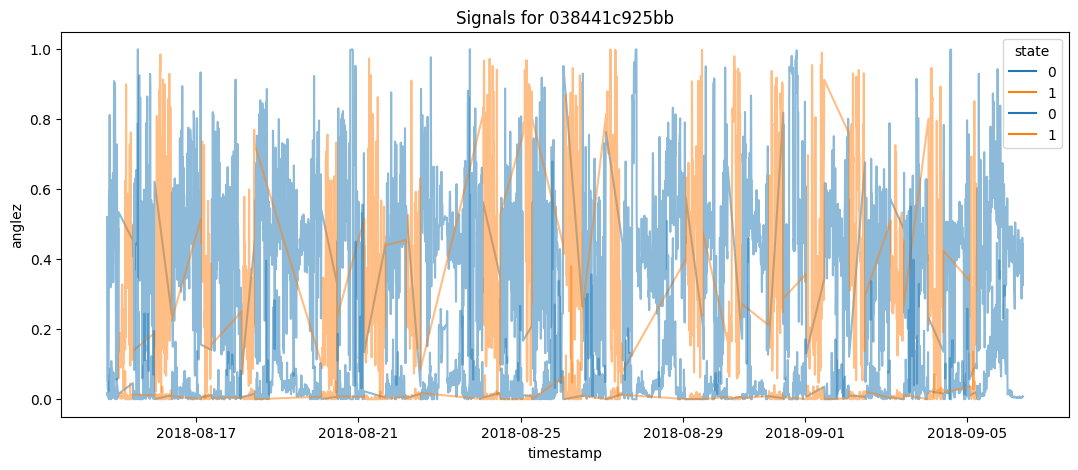

In [13]:
_, ax = plt.subplots(figsize=(13, 5))
# Filter signals for the given serie_id and sort by timestamp
serie_signals = df.filter(df["series_id"] == serie_id).sort(
    "timestamp"
)
sns.lineplot(
    data=serie_signals[::100], x="timestamp", y="anglez", alpha=0.5, hue='state'
)
sns.lineplot(data=serie_signals[::100], x="timestamp", y="enmo",hue='state', alpha=0.5)
ax.set_title(f"Signals for {serie_id}")


# Filter events for the given serie_id and sort by timestamp
serie_events = df.filter(df["series_id"] == serie_id).sort(
    "timestamp"
)

# Initialize containers for onsets and wakeups
onset_times = []
wakeup_times = []





In [18]:
fig,ax = plt.subplots(figsize=(13,5))
# Process events in order, pairing onsets with subsequent wakeups
for row in serie_events.iter_rows():
    if row[5] == 1:
        onset_times.append(row[1])
    elif row[5] == 0 and onset_times:
        # Only plot if there is a previous 'onset' to pair with
        onset = onset_times.pop()
        wakeup = row[1]

        ax.plot(
            [onset, wakeup],
            [0.5, 0.5],
            color="blue",
            lw=10,
            solid_capstyle="butt",
        )

ax.set_yticks([])
ax.set_xlabel("Time")
ax.set_title(f"Sleep Periods for {serie_id}")

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


**Missing Data**

Remove signals 6 hours after awake and 6 hours before sleep when an annotation is missing

In [12]:
# For each parquet file representing a time series
# We will sort them by timestamp
# if there are periods with 20 hours without sleep
# We will remove a period of 16 hours because we consider the annotations as missing

**Smoothing**

In [13]:
# Your code here ...

**Stratified Export**

In [14]:
# Your code here ...